## Initalize Field

In [1]:
# pip install numpy
# pip install matplotlib
# pip install scikit-image
# pip install LightPipes
# pip install scipy

In [2]:
import matplotlib.pyplot as plt
import numpy as np 
from scipy import fftpack

In [3]:
Lx = 100e-6
Ly = 100e-6
dim = 4000

# X-ray parameters
wavelength = 0.15e-9
k = 2*np.pi/wavelength
SI_c = 299792458
omega = SI_c*k

# Create grid
x = np.linspace(-Lx / 2, Lx / 2, dim)
y = np.linspace(-Ly / 2, Ly / 2, dim)
dx = dy = Lx / dim
X, Y = np.meshgrid(x, y)
print('dx:', dx)

# Plane wave field
E_0 = np.ones([dim,dim], dtype = np.complex128)

# Pinhole
R = 30e-6 / 2
E_0 [np.sqrt(X**2 + Y**2) > R] = 0 +0j

dx: 2.5000000000000002e-08


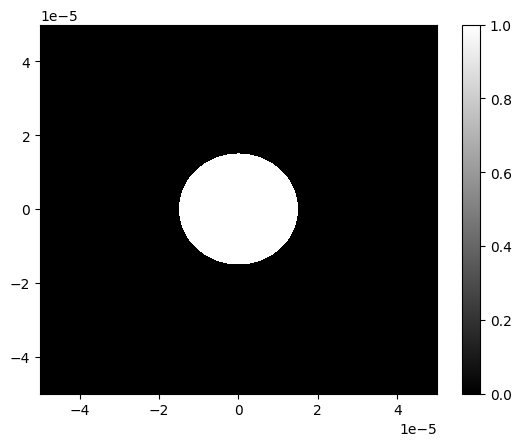

In [4]:
%matplotlib inline

# Plot Initial Intensity distribution
plt.imshow(np.abs(E_0), cmap='gray', interpolation='nearest',extent=[min(x),max(x), min(y),max(y)],aspect='auto')
plt.colorbar()
plt.show() 

## Zone Plate

In [5]:
# Zone Plate

# FZP parameters
m2 = 60 # workaround to account for 'intenionaly' making the focus larger - by incresing the source size (decreasing spatial coherence)
Delta_r = 100e-9
D = 750e-6
f = D*Delta_r/wavelength
print('f:', f)
NA = D/f
w_0 = m2*wavelength/np.pi/NA
print('w_0: ', w_0)

z_R = np.pi*w_0**2/(m2*wavelength)
print('z_R: ', z_R)
z_0 = 0
#R_0 = z_0 * (1+(z_R/z_0)**2)
w_ = w_0 * np.sqrt((1+(z_0/z_R)**2))
print('w_: ', w_)
E_0 = E_0*np.exp(-(X**2 + Y**2)/w_**2)#*np.exp(-1j*k*(X**2 + Y**2)/2/R_0)


f: 0.5
w_0:  1.909859317102744e-06
z_R:  0.0012732395447351628
w_:  1.909859317102744e-06


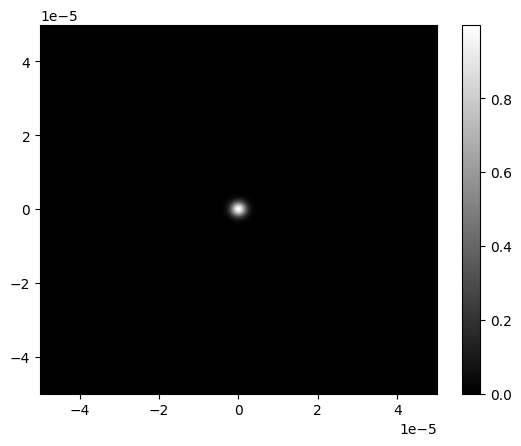

In [6]:
%matplotlib inline

# Plot Initial Intensity distribution
plt.imshow(np.abs(E_0), cmap='gray', interpolation='nearest',extent=[min(x),max(x), min(y),max(y)],aspect='auto')
plt.colorbar()
plt.show() 

## Diffuser

In [7]:
from LightPipes import *

# Open the file and read the position (x, y) data
file_path = 'Design/FFrand/Mffr20.txt'
position_data = []

with open(file_path, 'r') as file:
    for i, line in enumerate(file):
        if i == 0: continue
        values = line.split()
        if len(values) == 2:
            x, y = map(float, values)
            position_data.append((nm*x, nm*y))

position_data = np.array(position_data)
print('Nr holes: ', len(position_data))
#print(position_data[::1000])

Nr holes:  19936


In [8]:
from skimage.draw import disk

dim = np.shape(E_0)[0]
radius = 300*nm / 2 /Lx * dim
feat_size = 300*nm

circular_mask = np.zeros((dim, dim), dtype=bool)

for x, y in position_data:
    rr, cc = disk((x/Lx * dim + dim//2, y/Ly * dim + dim//2), radius, shape=(dim, dim))
    circular_mask[rr, cc] = True


Amp_grid = np.zeros([dim,dim])
Amp_grid[circular_mask] = 0.6

Phase_grid = np.zeros([dim,dim])
Phase_grid[~circular_mask] = np.pi

D = np.multiply(Amp_grid,np.exp(1j*Phase_grid))
E_0 = E_0 * D

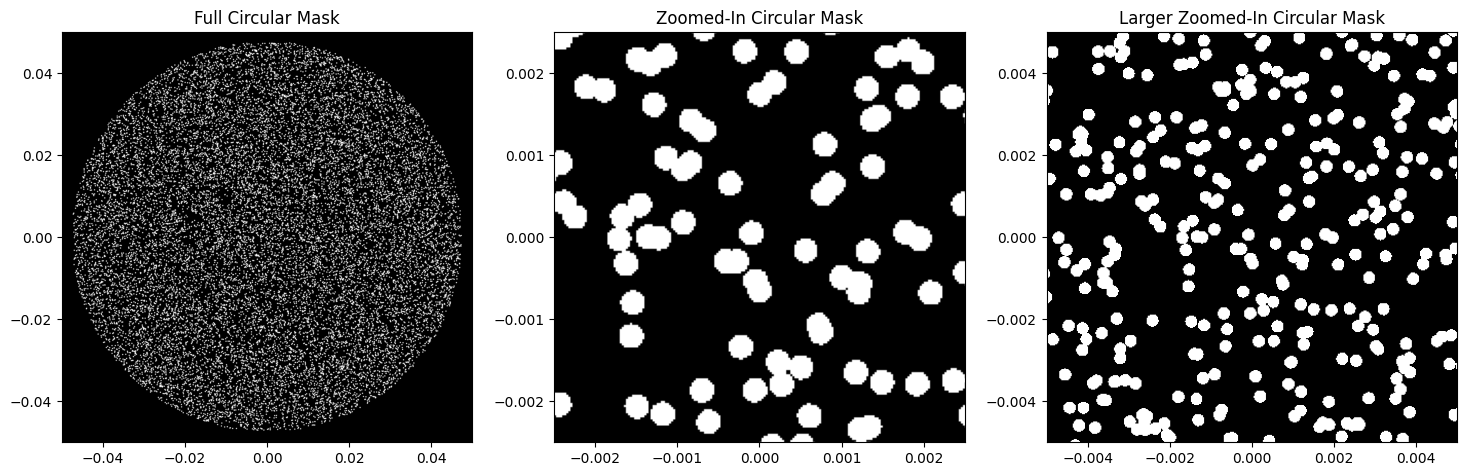

In [9]:
%matplotlib inline

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Full circular mask
ax1.imshow(circular_mask, cmap='gray', extent=[-Lx/2/mm, Lx/2/mm, -Lx/2/mm, Lx/2/mm])
ax1.set_title('Full Circular Mask')

# Zoomed-in circular mask
zoom_center = (0, 0)  # Define the center of the zoomed-in area
zoom_size = 5*um  # Define the size of the zoomed-in area
ax2.imshow(circular_mask, cmap='gray', extent=[-Lx/2/mm, Lx/2/mm, -Lx/2/mm, Lx/2/mm])
ax2.set_xlim(zoom_center[0] - zoom_size/2/mm, zoom_center[0] + zoom_size/2/mm)
ax2.set_ylim(zoom_center[1] - zoom_size/2/mm, zoom_center[1] + zoom_size/2/mm)
ax2.set_title('Zoomed-In Circular Mask')

# Larger zoomed-in circular mask
larger_zoom_size = 2 * zoom_size  # Define the size of the larger zoomed-in area
ax3.imshow(circular_mask, cmap='gray', extent=[-Lx/2/mm, Lx/2/mm, -Lx/2/mm, Lx/2/mm])
ax3.set_xlim(zoom_center[0] - larger_zoom_size/2/mm, zoom_center[0] + larger_zoom_size/2/mm)
ax3.set_ylim(zoom_center[1] - larger_zoom_size/2/mm, zoom_center[1] + larger_zoom_size/2/mm)
ax3.set_title('Larger Zoomed-In Circular Mask')

plt.show()

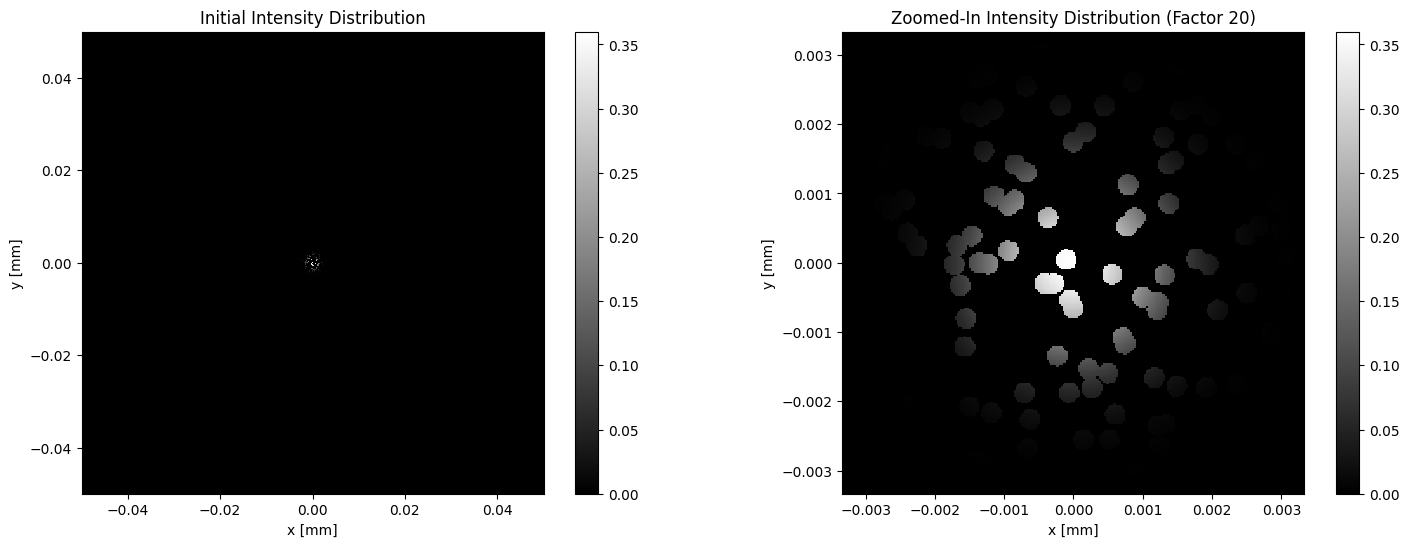

In [10]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot the initial intensity distribution
ax1.imshow(np.abs(E_0)**2, cmap='gray', interpolation='nearest', extent=[-Lx/2/mm, Lx/2/mm, -Lx/2/mm, Lx/2/mm])
ax1.set_title('Initial Intensity Distribution')
ax1.set_xlabel('x [mm]')
ax1.set_ylabel('y [mm]')
fig.colorbar(ax1.images[0], ax=ax1)
ax1.set_ylabel('y [mm]')

# Define the zoom factor
zoom_factor = 15

# Calculate new extents for the zoomed-in plot
new_extent = [-Lx/2/mm/zoom_factor, Lx/2/mm/zoom_factor, -Lx/2/mm/zoom_factor, Ly/2/mm/zoom_factor]

# Adjust the zoom factor for the data by restricting to the central data
center = dim // 2
zoomed_dim = dim // zoom_factor

zoomed_E_0 = np.abs(E_0)[center-zoomed_dim//2:center+zoomed_dim//2, center-zoomed_dim//2:center+zoomed_dim//2]**2

# Plot the zoomed-in intensity distribution
ax2.imshow(zoomed_E_0, cmap='gray', interpolation='nearest', extent=new_extent)
ax2.set_title('Zoomed-In Intensity Distribution (Factor 20)')
ax2.set_xlabel('x [mm]')
ax2.set_ylabel('y [mm]')
fig.colorbar(ax2.images[0], ax=ax2)

plt.show()

## Slits

In [11]:
def create_grid(rows, cols,slit_width, phase_diff_):

    # Create a grid filled phase shift
    grid = np.zeros([rows,cols])   

    # Define the center column
    center = cols // 2

    # Calculate positions of the two slits based on the slit distance
    left_most_slit = center - 4*(slit_width)
    left_slit = center - 2*(slit_width) 
    center_slit = center 
    right_slit = center + 2*(slit_width)
    right_most_slit = center + 4*(slit_width)

    # Create the slits (vertical lines with 0s)
    grid[center-center//2:center+center//2, (left_most_slit- slit_width//2):(left_most_slit + slit_width//2)] = phase_diff_
    grid[center-center//2:center+center//2, (left_slit- slit_width//2):(left_slit + slit_width//2)] = phase_diff_
    grid[center-center//2:center+center//2, (center_slit- slit_width//2):(center_slit + slit_width//2)] = phase_diff_
    grid[center-center//2:center+center//2, (right_slit- slit_width//2):(right_slit + slit_width//2)] = phase_diff_
    grid[center-center//2:center+center//2, (right_most_slit- slit_width//2):(right_most_slit + slit_width//2)] = phase_diff_

    return grid

def create_grid2(rows, cols,slit_width, att1,att2):

    # Create a grid filled phase shift
    grid = np.ones([rows,cols])*att1

    # Define the center column
    center = cols // 2

    left_most_slit = center - 4*(slit_width)
    left_slit = center - 2*(slit_width) 
    center_slit = center 
    right_slit = center + 2*(slit_width)
    right_most_slit = center + 4*(slit_width)

    # Create the slits (vertical lines with 0s)
    grid[center-center//2:center+center//2, (left_most_slit- slit_width//2):(left_most_slit + slit_width//2)] = att2
    grid[center-center//2:center+center//2, (left_slit- slit_width//2):(left_slit + slit_width//2)] = att2
    grid[center-center//2:center+center//2, (center_slit- slit_width//2):(center_slit + slit_width//2)] = att2
    grid[center-center//2:center+center//2, (right_slit- slit_width//2):(right_slit + slit_width//2)] = att2
    grid[center-center//2:center+center//2, (right_most_slit- slit_width//2):(right_most_slit + slit_width//2)] = att2

    return grid

In [12]:
# Computational Parameters
rows = dim        # Number of rows in the grid
cols = dim        # Number of columns in the grid
feat_size = .5e-6 # Slit width
d = int(feat_size/ dx)

# X-ray parameters
E = 8000 # Photon energy [eV]
wavelength = (1239.8 / E)*1e-9; # Photon wavelength [m]
omega=E/4.1e-15;

# Target parameters
Z = 74 # Atomic number
n_a = 19.3 # atomic density [g/cm3]
n_a_SI = n_a /196.97/(1.67e-24)*1e6 # atomic density [SI]
n_e = n_a_SI * (Z) # atomic density [SI]
thickness = 1.6e-6 # [m]

r0 = 2.8e-15 # Classical electron radius [m]
delta = (r0*wavelength**2*n_e)*omega/SI_c 
phase_diff=(delta * thickness) # this is the phase difference between air and W of a given thickness
phase_diff = np.pi
Transmission = 0.45

# Create the grid
Phase_grid = create_grid(rows, cols, d, phase_diff)
Amp_grid = create_grid2(rows, cols, d, Transmission, 1)

D = np.multiply(Amp_grid,np.exp(1j*Phase_grid))
E_1 = E_0 * D

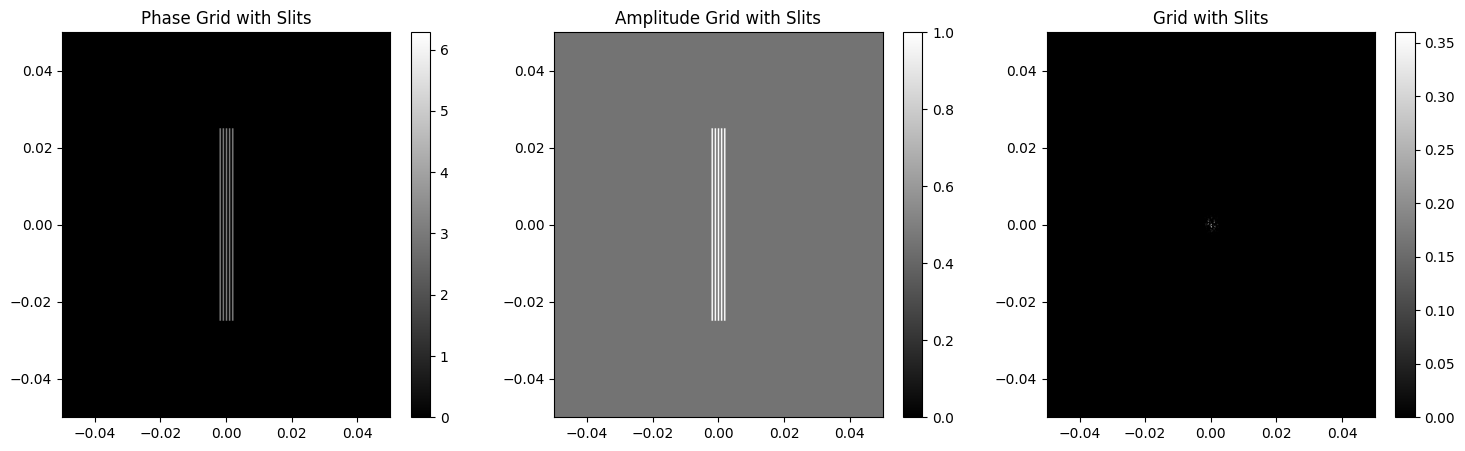

In [13]:
%matplotlib inline

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Plot the phase grid using a heatmap
im1 = ax1.imshow(Phase_grid, cmap='gray', extent=[-Lx/2/mm, Lx/2/mm, -Lx/2/mm, Lx/2/mm], aspect='auto', vmin=0, vmax=2*np.pi)
ax1.set_title("Phase Grid with Slits")
fig.colorbar(im1, ax=ax1)

# Plot the amplitude grid using a heatmap
im2 = ax2.imshow(Amp_grid, cmap='gray', extent=[-Lx/2/mm, Lx/2/mm, -Lx/2/mm, Lx/2/mm], aspect='auto', vmin=0, vmax=1)
ax2.set_title("Amplitude Grid with Slits")
fig.colorbar(im2, ax=ax2)

# Plot the grid using a heatmap
im3 = ax3.imshow(np.abs(E_1)**2, cmap='gray', extent=[-Lx/2/mm, Lx/2/mm, -Lx/2/mm, Lx/2/mm], aspect='auto')
ax3.set_title("Grid with Slits")
fig.colorbar(im3, ax=ax3)

plt.show()

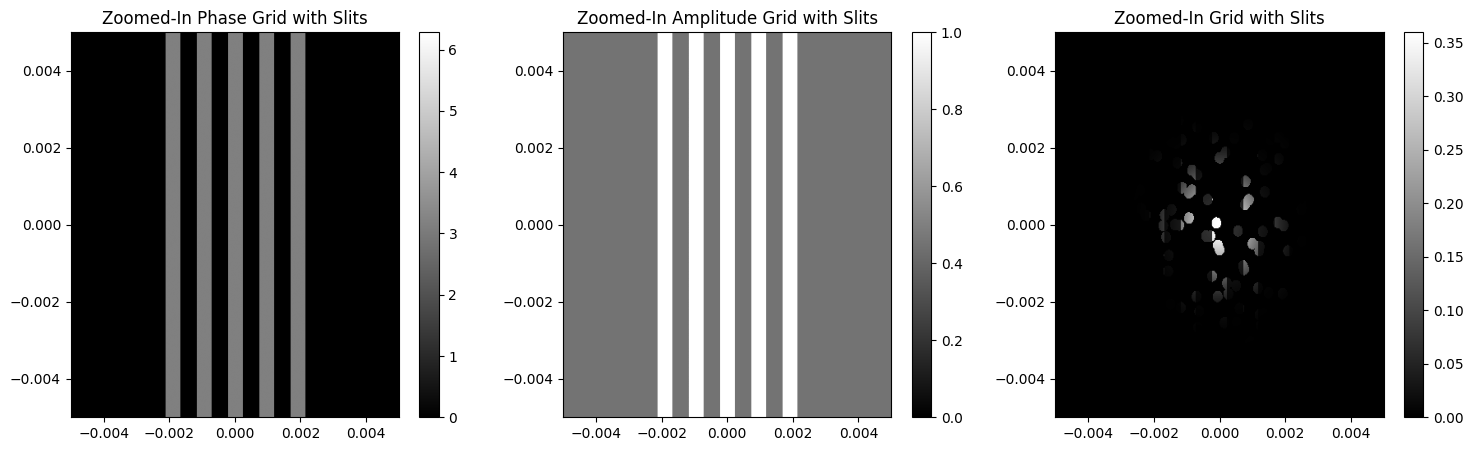

In [14]:
%matplotlib inline

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Define the zoom factor
zoom_factor = 10

# Calculate new extents
new_extent = [-Lx/2/mm/zoom_factor, Lx/2/mm/zoom_factor, -Lx/2/mm/zoom_factor, Ly/2/mm/zoom_factor]

# Adjust the zoom factor for the data by restricting to the central data
center = dim // 2
zoomed_dim = dim // zoom_factor

zoomed_phase_grid = Phase_grid[center-zoomed_dim//2:center+zoomed_dim//2, center-zoomed_dim//2:center+zoomed_dim//2]
zoomed_amp_grid = Amp_grid[center-zoomed_dim//2:center+zoomed_dim//2, center-zoomed_dim//2:center+zoomed_dim//2]
zoomed_E_1 = np.abs(E_1)[center-zoomed_dim//2:center+zoomed_dim//2, center-zoomed_dim//2:center+zoomed_dim//2]**2

# Plot the zoomed-in phase grid using a heatmap
im1 = ax1.imshow(zoomed_phase_grid, cmap='gray', extent=new_extent, aspect='auto', vmin=0, vmax=2*np.pi)
ax1.set_title("Zoomed-In Phase Grid with Slits")
fig.colorbar(im1, ax=ax1)

# Plot the zoomed-in amplitude grid using a heatmap
im2 = ax2.imshow(zoomed_amp_grid, cmap='gray', extent=new_extent, aspect='auto', vmin=0, vmax=1)
ax2.set_title("Zoomed-In Amplitude Grid with Slits")
fig.colorbar(im2, ax=ax2)

# Plot the zoomed-in grid using a heatmap
im3 = ax3.imshow(zoomed_E_1, cmap='gray', extent=new_extent, aspect='auto')
ax3.set_title("Zoomed-In Grid with Slits")
fig.colorbar(im3, ax=ax3)

plt.show()

## Propagate

In [15]:
#E_1 = E_0

z_prop = 5.1 # propagation distance in m
#pixel_size = 50e-6
def franhoffer_propagation(Field, wavelength, z_prop, dx, dy):
  
    Nx, Ny = Field.shape

    # Fourier transform of the field
    Field_ft = np.fft.fftshift(np.fft.fft2(Field))

    Field_propagated = np.exp(1j*2*np.pi/wavelength*z_prop)/1j/wavelength/z_prop*(Field_ft)
    x_NF = np.linspace(-Nx/2,Nx/2,Nx)*dx
    y_NF = np.linspace(-Ny/2,Ny/2,Nx)*dy
    x_FF = np.linspace(-(wavelength*z_prop/2/dx),(wavelength*z_prop/2/dx),Nx)
    y_FF = np.linspace(-(wavelength*z_prop/2/dy),(wavelength*z_prop/2/dy),Ny)

    return Field_ft, x_FF, y_FF

E_2, x_FF, y_FF = franhoffer_propagation(E_1,wavelength, z_prop, dx,dy)


## Plot Diffraction

C:\Users\Laptop 2\AppData\Local\Temp\ipykernel_14856\205173895.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


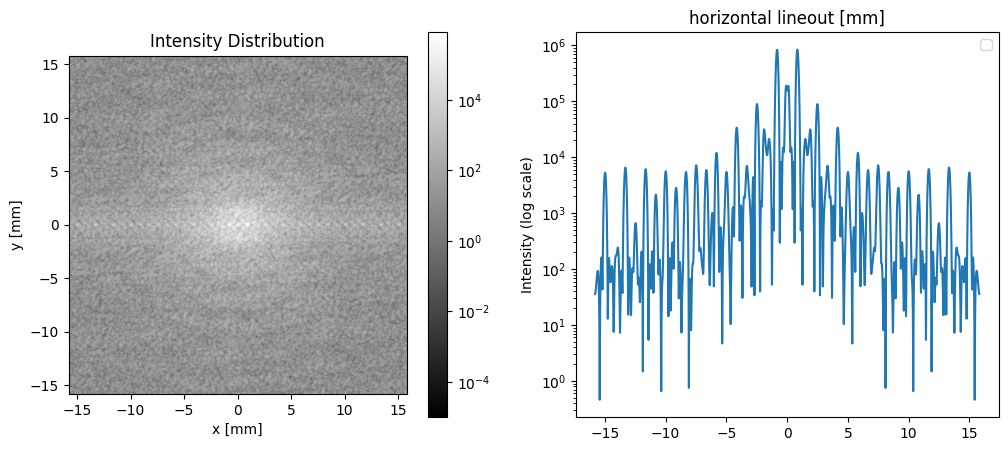

In [16]:
%matplotlib inline

from matplotlib.colors import LogNorm

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the intensity distribution
im = ax1.imshow(np.abs(E_2)**2, extent=[1e3*np.min(x_FF),1e3*np.max(x_FF),1e3*np.min(y_FF),1e3*np.max(y_FF)], cmap='gray', norm=LogNorm())
ax1.set_title('Intensity Distribution')
ax1.set_xlabel('x [mm]')
ax1.set_ylabel('y [mm]')
fig.colorbar(im, ax=ax1)

# Plot the Fraunhofer intensity and theoretical fringes
ax2.plot(1e3*x_FF, np.abs(E_2[int(dim/2), :])**2)
#ax2.set_xlim([-2, 2])
ax2.set_yscale('log')
ax2.set_title('horizontal lineout [mm]')
ax2.set_ylabel('Intensity (log scale)')
ax2.legend()

plt.show()

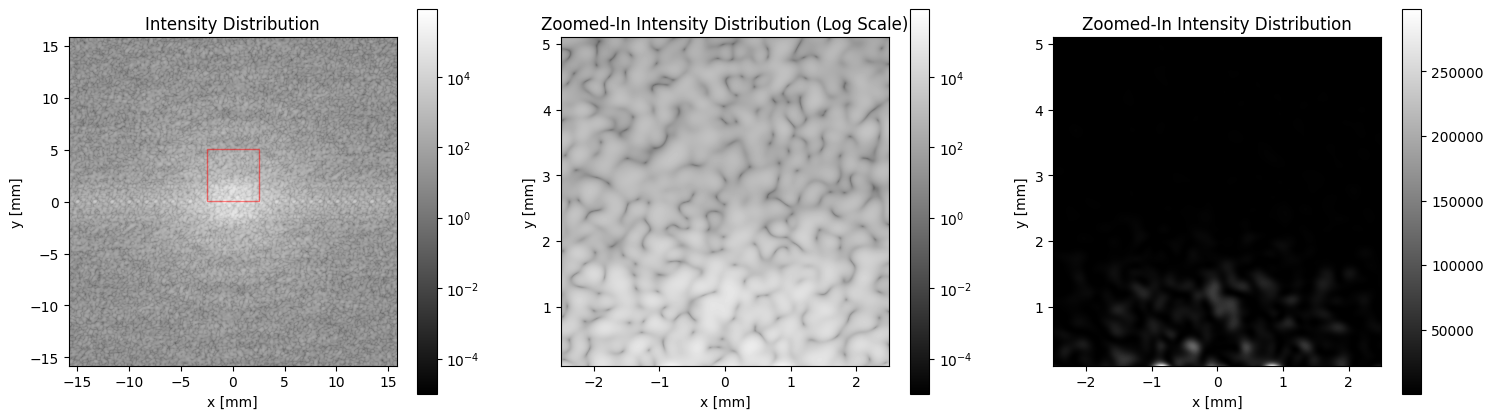

In [17]:
%matplotlib inline

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Plot the intensity distribution
im = ax1.imshow(np.abs(E_2)**2, extent=[1e3*np.min(x_FF), 1e3*np.max(x_FF), 1e3*np.min(y_FF), 1e3*np.max(y_FF)], cmap='gray', norm=LogNorm())
ax1.set_title('Intensity Distribution')
ax1.set_xlabel('x [mm]')
ax1.set_ylabel('y [mm]')
fig.colorbar(im, ax=ax1)

# Zoomed-in intensity distribution with log scaling
zoom_center = (0, 2.6e-3)  # Define the center of the zoomed-in area
zoom_size = 5e-3  # Define the size of the zoomed-in area
im_zoom_log = ax2.imshow(np.abs(E_2)**2, extent=[1e3*np.min(x_FF), 1e3*np.max(x_FF), 1e3*np.min(y_FF), 1e3*np.max(y_FF)], cmap='gray', norm=LogNorm())

# Add a red low alpha box in ax1 where the zoom is placed
rect = plt.Rectangle((1e3*zoom_center[0] - 1e3*zoom_size/2, 1e3*zoom_center[1] - 1e3*zoom_size/2), 1e3*zoom_size, 1e3*zoom_size, 
                     linewidth=1, edgecolor='r', facecolor='none', alpha=0.5)
ax1.add_patch(rect)

ax2.set_xlim(1e3*zoom_center[0] - 1e3*zoom_size/2, 1e3*zoom_center[0] + 1e3*zoom_size/2)
ax2.set_ylim(1e3*zoom_center[1] - 1e3*zoom_size/2, 1e3*zoom_center[1] + 1e3*zoom_size/2)
ax2.set_title('Zoomed-In Intensity Distribution (Log Scale)')
ax2.set_xlabel('x [mm]')
ax2.set_ylabel('y [mm]')
fig.colorbar(im_zoom_log, ax=ax2)

# Zoomed-in intensity distribution without log scaling
xlim = (zoom_center[0] - zoom_size/2, zoom_center[0] + zoom_size/2)
ylim = (zoom_center[1] - zoom_size/2, zoom_center[1] + zoom_size/2)

zoomed_data = np.abs(E_2)**2
zoomed_data = zoomed_data[(y_FF >= ylim[0]) & (y_FF <= ylim[1])][:, (x_FF >= xlim[0]) & (x_FF <= xlim[1])]
im_zoom = ax3.imshow(np.flipud(zoomed_data), extent=[1e3*xlim[0], 1e3*xlim[1], 1e3*ylim[0], 1e3*ylim[1]], cmap='gray', vmin=np.min(zoomed_data), vmax=np.max(zoomed_data))
ax3.set_title('Zoomed-In Intensity Distribution')
ax3.set_xlabel('x [mm]')
ax3.set_ylabel('y [mm]')
fig.colorbar(im_zoom, ax=ax3)

plt.show()

## Detector Resolution

In [18]:
from scipy.ndimage import zoom

Pixel = 512
dPixel = 55e-6

detector_size = Pixel*dPixel
detector_center = (0, -1.2*detector_size / 2)
print('detector size:', detector_size)
print('detector center:', detector_center)

# Zoomed-in intensity distribution without log scaling
xlim = (detector_center[0] - detector_size/2, detector_center[0] + detector_size/2)
ylim = (detector_center[1] - detector_size/2, detector_center[1] + detector_size/2)

detector_data = np.abs(E_2)**2
detector_data = detector_data[(y_FF >= ylim[0]) & (y_FF <= ylim[1])][:, (x_FF >= xlim[0]) & (x_FF <= xlim[1])]

# Calculate the scaling factor
scaling_factor = (x_FF[1] - x_FF[0]) / dPixel
print('sim resolution:', x_FF[1] - x_FF[0])
print('scaling factor:', scaling_factor)

# Interpolate the detector data
interpolated_detector_data = zoom(detector_data, scaling_factor)


detector size: 0.02816
detector center: (0, -0.016896)
sim resolution: 7.905701425357792e-06
scaling factor: 0.1437400259155962


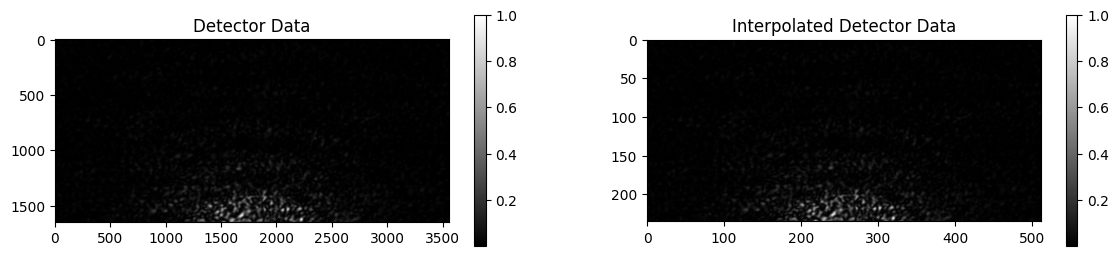

In [19]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 3))

# Plot the detector data
im1 = ax1.imshow(detector_data/ np.amax(detector_data), cmap='gray')
ax1.set_title('Detector Data')
fig.colorbar(im1, ax=ax1)

# Plot the interpolated detector data
im2 = ax2.imshow(interpolated_detector_data/ np.amax(interpolated_detector_data), cmap='gray')
ax2.set_title('Interpolated Detector Data')
fig.colorbar(im2, ax=ax2)

plt.show()


## Compute G2 

In [20]:
np.shape(interpolated_detector_data)

(236, 512)

In [22]:
%matplotlib inline

from scipy.signal import fftconvolve

# Create a rolled image with 3x3 the dimensions of the original image
image_rolled = np.tile(interpolated_detector_data, (3, 3))

# Calculate the autocorrelation using FFT convolution
autocorrelation = fftconvolve(image_rolled, interpolated_detector_data[::-1, ::-1], mode='valid')

# Cut out the center of the autocorrelation with the dimensions of the original image
center_x, center_y = autocorrelation.shape[1] // 2, autocorrelation.shape[0] // 2
half_width, half_height = interpolated_detector_data.shape[1] // 2, interpolated_detector_data.shape[0] // 2
autocorrelation = autocorrelation[center_y - half_height:center_y + half_height, center_x - half_width:center_x + half_width]

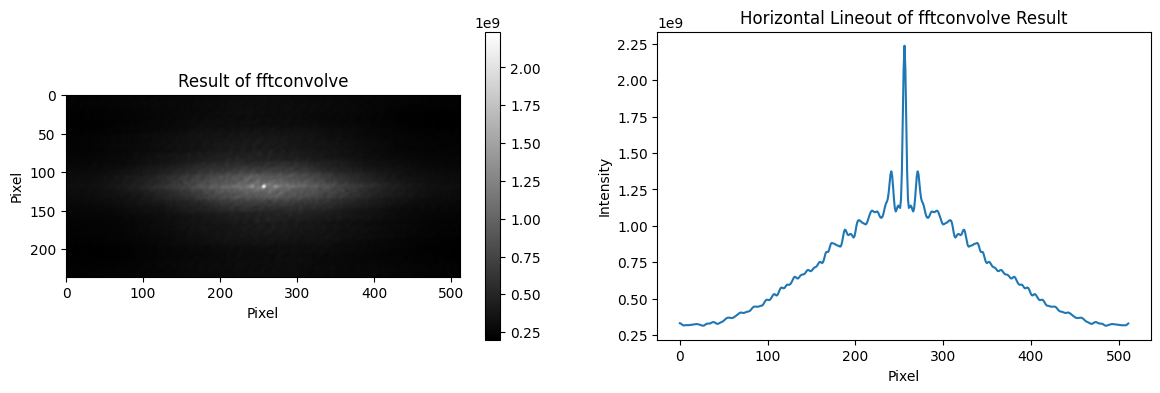

In [24]:
# Plot the result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.imshow(autocorrelation, cmap='gray')
ax1.set_title('Result of fftconvolve')
ax1.set_xlabel('Pixel')
ax1.set_ylabel('Pixel')
fig.colorbar(ax1.images[0], ax=ax1)

# Plot a horizontal lineout
ax2.plot(autocorrelation[autocorrelation.shape[0] // 2, :])
ax2.set_title('Horizontal Lineout of fftconvolve Result')
ax2.set_xlabel('Pixel')
ax2.set_ylabel('Intensity')

plt.show()

In [25]:
import numpy as np

def g2_correlation_Lucas(intensity_image, q_vector):
    # Convert q_vector to numpy array if it's not already one
    q_vector = np.array(q_vector)

    Im_disp = np.roll(intensity_image, shift=q_vector, axis=(0, 1))

    numerator = np.mean(intensity_image * Im_disp)
    denominator = np.mean(intensity_image) ** 2

    # Compute the normalized second-order correlation
    g2 = numerator / denominator

    return g2

In [29]:
import time
import numpy as np
import concurrent.futures

# Create a numpy array image
N_corr_c2 = 256  # number of pixels to use for the auto-correlation
c2j = np.zeros([N_corr_c2, N_corr_c2])

def compute_g2(q1, q2, image):
    return g2_correlation_Lucas(image, [q1, q2])

q_range = range(-int(N_corr_c2 / 2) - 1, int(N_corr_c2 / 2) - 1, 1)
q_pairs = [(q1, q2) for q1 in q_range for q2 in q_range]

start_time = time.time()

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(executor.map(lambda q: compute_g2(q[0], q[1], interpolated_detector_data), q_pairs))

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

for idx, (q1, q2) in enumerate(q_pairs):
    c2j[q2 + int(N_corr_c2 / 2) + 1, q1 + int(N_corr_c2 / 2) + 1] = results[idx]

# Rotate the result by 90 degrees
c2j = np.rot90(c2j)

# Mirror the result vertically
c2j = np.flipud(c2j)

Execution time: 33.067302942276 seconds


Text(0, 0.5, 'Intensity')

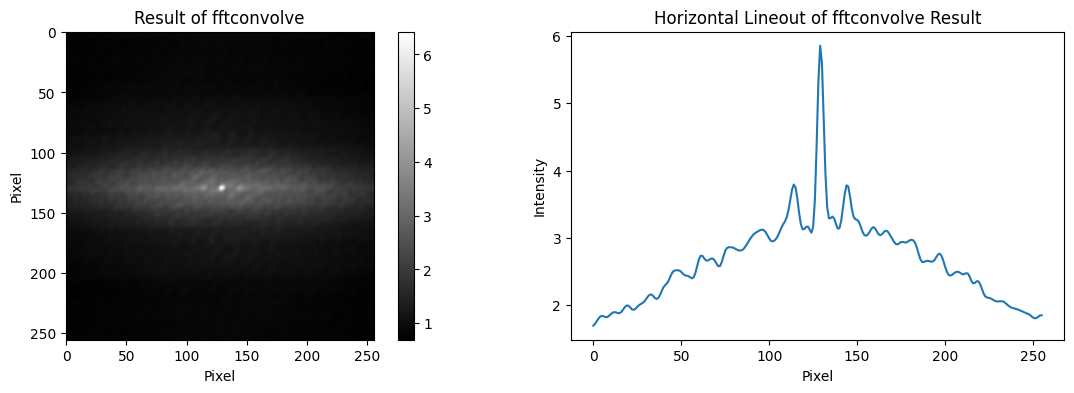

In [30]:
# Plot the result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.imshow(c2j, cmap='gray')
ax1.set_title('Result of fftconvolve')
ax1.set_xlabel('Pixel')
ax1.set_ylabel('Pixel')
fig.colorbar(ax1.images[0], ax=ax1)

# Plot a horizontal lineout
ax2.plot(c2j[c2j.shape[0] // 2, :])
ax2.set_title('Horizontal Lineout of fftconvolve Result')
ax2.set_xlabel('Pixel')
ax2.set_ylabel('Intensity')